# Wild Animal Prediction using Vision Transformation

### Importing required libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.utils import save_image
from torchvision import datasets
from torchsummary import summary

import spacy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import time
import math
from PIL import Image
import glob
from IPython.display import display
from tensorflow import keras

### Setting up GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
torch.manual_seed(0)
np.random.seed(0)

### Setting batch size and epoch values

In [4]:
BATCH_SIZE = 16
LR = 5e-5
NUM_EPOCHES = 100

In [5]:
mean, std = (0.5,), (0.5,)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std),
                              ])

### Loading Images from data folder

In [6]:
train_data = datasets.ImageFolder('data/train/',transform=transform)
test_data = datasets.ImageFolder('data/test/',transform=transform)

In [7]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False,)

In [8]:
trainloader.dataset

Dataset ImageFolder
    Number of datapoints: 2339
    Root location: data/train/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [9]:
for img, label in trainloader:
    print(img[10].shape)
    break

torch.Size([3, 224, 224])


### Importing ViT model

In [10]:
from transformer_package.models import ViT

In [11]:
image_size = 224
channel_size = 3
patch_size = 32
embed_size = 512
num_heads = 8
classes = 10
num_layers = 3
hidden_size = 512
dropout = 0.2

model = ViT(image_size, channel_size, patch_size, embed_size, num_heads, classes, num_layers, hidden_size, dropout=dropout).to(device)
model

ViT(
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (embeddings): Linear(in_features=3072, out_features=512, bias=True)
  (encoders): ModuleList(
    (0-2): 3 x VisionEncoder(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (dropout_layer): Dropout(p=0.2, inplace=False)
        (Q): Linear(in_features=512, out_features=512, bias=True)
        (K): Linear(in_features=512, out_features=512, bias=True)
        (V): Linear(in_features=512, out_features=512, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (norm): 

In [12]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

### training the model and predicting the accuracy

In [13]:
loss_hist = {}
loss_hist["train accuracy"] = []
loss_hist["train loss"] = []

for epoch in range(1, NUM_EPOCHES+1):
    model.train()
    
    epoch_train_loss = 0
        
    y_true_train = []
    y_pred_train = []
        
    for batch_idx, (img, labels) in enumerate(trainloader):
        # t = transforms.Grayscale()
        # img = t(img)
        img = img.to(device)
        labels = labels.to(device)
        
        preds = model(img)
        
        loss = criterion(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        y_pred_train.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_train.extend(labels.detach().tolist())
          
        epoch_train_loss += loss.item()
    
    loss_hist["train loss"].append(epoch_train_loss)
    
    total_correct = len([True for x, y in zip(y_pred_train, y_true_train) if x==y])
    total = len(y_pred_train)
    accuracy = total_correct * 100 / total
    
    loss_hist["train accuracy"].append(accuracy)
    
    print("-------------------------------------------------")
    print("Epoch: {} Train mean loss: {:.8f}".format(epoch, epoch_train_loss))
    print("       Train Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")

-------------------------------------------------
Epoch: 1 Train mean loss: 338.95232141
       Train Accuracy%:  14.2368533561351 == 333 / 2339
-------------------------------------------------
-------------------------------------------------
Epoch: 2 Train mean loss: 328.91133690
       Train Accuracy%:  17.229585292860197 == 403 / 2339
-------------------------------------------------
-------------------------------------------------
Epoch: 3 Train mean loss: 323.03465927
       Train Accuracy%:  19.83753740914921 == 464 / 2339
-------------------------------------------------
-------------------------------------------------
Epoch: 4 Train mean loss: 313.82708097
       Train Accuracy%:  22.274476271911073 == 521 / 2339
-------------------------------------------------
-------------------------------------------------
Epoch: 5 Train mean loss: 309.24150062
       Train Accuracy%:  24.027362120564344 == 562 / 2339
-------------------------------------------------
------------------

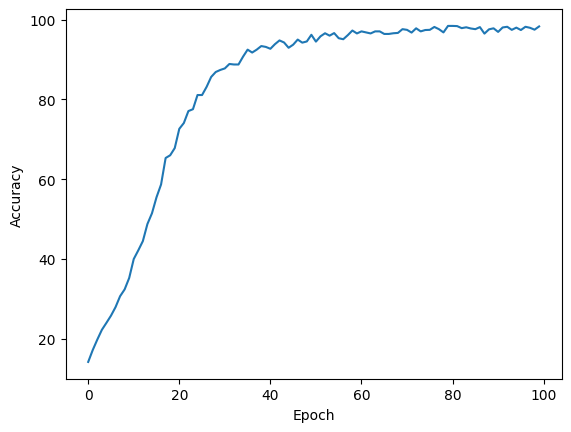

In [14]:
plt.plot(loss_hist["train accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()